<a href="https://colab.research.google.com/github/dineshRaja29/Input-Dimension-Free-CNN/blob/main/genericCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Shri Radhey

# <font color = 'green'><b>MOTIVATION:</b>


*   While building the CNN we need to take care of input dimensions so much that any slight change in dimension leads to a change in the whole dimension.
> *    A generic structure is needed which accepts any dimension of input.



# <font color = 'green'><b>GOAL:</b>
To build the CNN in such a way it can accept any dimensions of input.

**OBJECTIVE:** To build the CNN in such a way it can accept any dimensions of input and it can also be used as a features extractor for any kind of image with arbitrary dimensions

# <font color = 'green'><b>PERFORMANCE METRIC:</b>


*  Overall Accuracy
*  Multi-class precision and recall

# <font color = 'green'><b>DATASET:</b>


*  Source: https://research.zalando.com/project/fashion_mnist/fashion_mnist/
*  Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

# <font color = 'green'><b>EXPERIMENT:</b>

In [ ]:
# libraries
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [ ]:
BATCH_SIZE = 128
EPOCH = 15
NUMBER_OF_INPUT_CHANNEL = 1
NUMBER_OF_CLASSES = 10
LEARNING_RATE = 1e-3
BEST_LOSS = torch.inf
BEST_MODEL = './bestmodel.pth'

In [ ]:
def classification_report(model, loader, device):
    from sklearn.metrics import classification_report
    model.eval()
    correct = []
    total = []

    for idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        pred = model(images)
        correct.extend(pred.argmax(1).tolist())  # Use tolist() instead of item()
        total.extend(labels.tolist())  # Use tolist() instead of item()

    target_names = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat",
                    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
    print(classification_report(total, correct, target_names=target_names))

    return 0

In [ ]:
def accuracy_calculation(model, loader, device):

    model.eval()
    correct = 0.0
    total = 0.0

    for idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        pred = model(images)
        correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
        total += len(labels)

    accuracy = (correct / total) * 100

    return "{:.3f}".format(accuracy)


In [ ]:
# shifting the computations on the hardware accelerator
device = (torch.device("cuda")
          if torch.cuda.is_available()
          else torch.device("mps")
          if torch.backends.mps.is_available()
          else torch.device("cpu"))
print(f'Hardware Accelerator is {device}')

Hardware Accelerator is cuda


In [ ]:
%%capture
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)


In [ ]:
# checking whether images are RGB or Grayscale

image, label = training_data[0]
shape = image.shape[0]

if shape == 1:
    print('Images are Gray scale')
else:
    if shape == 3:
        print('Images are RGB')
    else:
        print('Something is out of place')
        raise Exception

Images are Gray scale


In [ ]:
# computing mean and std-dev
mean = 0.0
std = 0.0
total_samples = len(training_data)
for image, _ in training_data:
    mean += torch.mean(image)
    std += torch.std(image)

# normalizing for the entire data

mean /= total_samples
std /= total_samples

print(f'Mean of the data is {mean}')
print(f'Std-dev of the data is {std}')

Mean of the data is 0.28604063391685486
Std-dev of the data is 0.3204546272754669


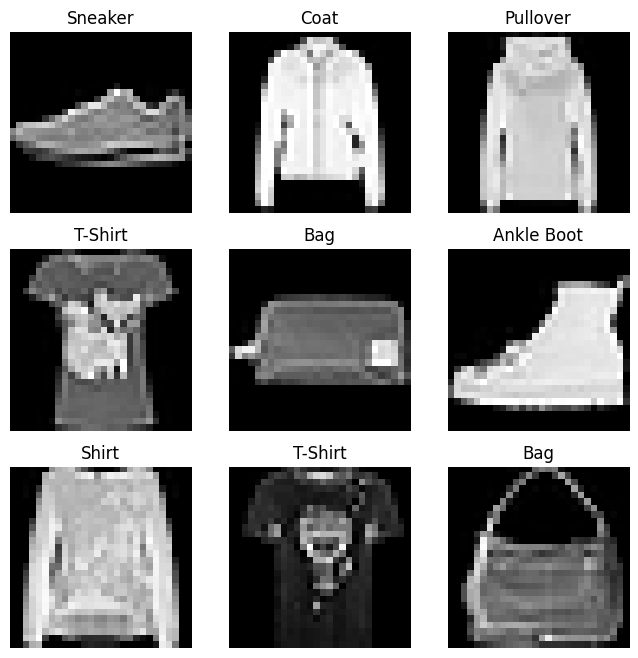

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # print(img.shape, img.squeeze().shape)
    plt.imshow(img.squeeze(), cmap="gray") # https://pytorch.org/docs/stable/generated/torch.squeeze.html
plt.show()

In [ ]:
del training_data
transformations = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize(mean, std),
                    ])


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transformations
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transformations
)


In [ ]:
print(f'Training Samples: {len(training_data)}')
print(f'Testing Samples: {len(test_data)}')

Training Samples: 60000
Testing Samples: 10000


In [ ]:
train_dataloader = DataLoader(training_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = torch.nn.Sequential(
                        torch.nn.Conv2d(NUMBER_OF_INPUT_CHANNEL, 256, 5, padding = 'same' ),
                        torch.nn.ReLU(),
                        torch.nn.MaxPool2d(2,2),
                        torch.nn.Conv2d(256, 128, 3, padding = 'same' ),
                        torch.nn.ReLU(),
                        torch.nn.MaxPool2d(2,2),
                        torch.nn.Conv2d(128, 64, 2, padding = 'same' ),
                        torch.nn.ReLU(),
                        torch.nn.MaxPool2d(2,2),
                        torch.nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = torch.nn.Sequential(
                        torch.nn.Linear(64, 32),
                        torch.nn.ReLU(),
                        torch.nn.Linear(32, NUMBER_OF_CLASSES)
        )

        self._initialize()  # Initialize the linear layers

    def _initialize(self):
        for layer in self.classifier:
            if isinstance(layer, torch.nn.Linear):
                print(f'Initializing layer {layer.__class__}')
                torch.nn.init.xavier_uniform_(layer.weight)
                torch.nn.init.zeros_(layer.bias)


    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, 1)  # Flatten the output before feeding to classifier
        x = self.classifier(x)
        return x



In [ ]:
model = Model()
model.to(device)
print(model)

Initializing layer <class 'torch.nn.modules.linear.Linear'>
Initializing layer <class 'torch.nn.modules.linear.Linear'>
Model(
  (backbone): Sequential(
    (0): Conv2d(1, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [ ]:
# Check if model parameters are on GPU
for name, param in model.named_parameters():
    print(f"Parameter {name} is on device: {param.device}")

Parameter backbone.0.weight is on device: cuda:0
Parameter backbone.0.bias is on device: cuda:0
Parameter backbone.3.weight is on device: cuda:0
Parameter backbone.3.bias is on device: cuda:0
Parameter backbone.6.weight is on device: cuda:0
Parameter backbone.6.bias is on device: cuda:0
Parameter classifier.0.weight is on device: cuda:0
Parameter classifier.0.bias is on device: cuda:0
Parameter classifier.2.weight is on device: cuda:0
Parameter classifier.2.bias is on device: cuda:0


In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE)

In [ ]:
for epoch in range(EPOCH):
    # model stage to training
    model.train()
    # running loss
    running_loss = 0
    for idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            predictions = model(images)
            loss = loss_function(predictions, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

    print(f'{epoch + 1}/{EPOCH}: Loss is {running_loss/(idx + 1)}')
    print(f'Accuracy: {accuracy_calculation(model, train_dataloader, device)} %')
    if running_loss < BEST_LOSS:
        BEST_LOSS = running_loss
        print(f'Saving the best model for Epoch {epoch +1}')
        torch.save(model.state_dict(), BEST_MODEL)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


1/15: Loss is 2.2061374228137898
Accuracy: 39.117 %
Saving the best model for Epoch 1
2/15: Loss is 2.003292555239663
Accuracy: 40.552 %
Saving the best model for Epoch 2
3/15: Loss is 1.7799427966827523
Accuracy: 48.670 %
Saving the best model for Epoch 3
4/15: Loss is 1.5847775582819859
Accuracy: 57.323 %
Saving the best model for Epoch 4
5/15: Loss is 1.3954870388197747
Accuracy: 63.073 %
Saving the best model for Epoch 5
6/15: Loss is 1.219822682297306
Accuracy: 64.675 %
Saving the best model for Epoch 6
7/15: Loss is 1.0795451429352831
Accuracy: 67.057 %
Saving the best model for Epoch 7
8/15: Loss is 0.9798052370675338
Accuracy: 68.687 %
Saving the best model for Epoch 8
9/15: Loss is 0.9129312535338818
Accuracy: 69.560 %
Saving the best model for Epoch 9
10/15: Loss is 0.867197701417561
Accuracy: 70.247 %
Saving the best model for Epoch 10
11/15: Loss is 0.8335542094224552
Accuracy: 70.873 %
Saving the best model for Epoch 11
12/15: Loss is 0.8073468238814299
Accuracy: 71.822 %


# <font color = 'green'><b>RESULTS:</b>



In [ ]:
print('Training Data')
print('\tClassification Report:')
print('\t\t',classification_report(model, train_dataloader, device))

Training Data
	Classification Report:
              precision    recall  f1-score   support

     T-Shirt       0.66      0.77      0.71      6000
     Trouser       0.98      0.91      0.94      6000
    Pullover       0.52      0.67      0.59      6000
       Dress       0.72      0.83      0.77      6000
        Coat       0.58      0.57      0.58      6000
      Sandal       0.79      0.82      0.81      6000
       Shirt       0.41      0.19      0.26      6000
     Sneaker       0.83      0.77      0.80      6000
         Bag       0.93      0.88      0.90      6000
  Ankle Boot       0.83      0.92      0.87      6000

    accuracy                           0.73     60000
   macro avg       0.73      0.73      0.72     60000
weighted avg       0.73      0.73      0.72     60000

		 0


In [ ]:
print('Testing Data')
print('\tClassification Report:')
print('\t\t',classification_report(model, test_dataloader, device))

Testing Data
	Classification Report:
              precision    recall  f1-score   support

     T-Shirt       0.65      0.75      0.69      1000
     Trouser       0.98      0.91      0.94      1000
    Pullover       0.51      0.67      0.58      1000
       Dress       0.72      0.80      0.75      1000
        Coat       0.57      0.57      0.57      1000
      Sandal       0.82      0.82      0.82      1000
       Shirt       0.36      0.17      0.23      1000
     Sneaker       0.84      0.80      0.82      1000
         Bag       0.91      0.88      0.90      1000
  Ankle Boot       0.82      0.93      0.87      1000

    accuracy                           0.73     10000
   macro avg       0.72      0.73      0.72     10000
weighted avg       0.72      0.73      0.72     10000

		 0


# <font color = 'green'><b>REFERENCES:</b>


*   https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
*   https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
*   https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html



